In [1]:
import requests
from bs4 import BeautifulSoup as bs
import re
import pathlib
import ezodf
import pandas as pd

In [2]:
url = "https://www.data.gov.uk/dataset/5d5028ef-9918-4ab7-8755-81f3ad06f308/pesticide-residues-in-food"

In [3]:
def get_soup(url): # integrated function to return parsed HTML
    return bs(requests.get(url).content)

soup = get_soup(url)

In [4]:
# getting a list of the links that contain ".ods" filename extension
file_urls = [a.get('href') for a in soup.find_all('a', href=True) if (re.search('ods',(a.get('href'))))] 

In [5]:
# don't want repeated data, so take annual data if available, then quarterly up to most recent
ann_file_urls = [x for x in file_urls if 'annual' in x.lower()]

def return_years_available(urls):
    years = []
    for url in urls:
        match = re.search(r'\d{4}', url)
        if match:
            year = match.group()
            years.append(year)
    return set(years)
        
        
years_available = return_years_available(file_urls)        
years_with_ann = return_years_available(ann_file_urls)

years_need_quarterly = list(years_available - years_with_ann)

In [6]:
# most recent quarterly urls where annual data isn't available
qua_file_urls = [x for x in file_urls if any(y in x for y in years_need_quarterly) and 'quarterly' in x.lower()]

In [7]:
file_urls = ann_file_urls + qua_file_urls

In [8]:
file_names = [re.search('([A-Za-z_0-9.-]*\.ods)', url).group() for url in file_urls]

In [9]:
file_urls

['https://s3.eu-west-1.amazonaws.com/data.defra.gov.uk/PRIF/2021_annual_data.ods',
 'https://s3.eu-west-1.amazonaws.com/data.defra.gov.uk/PRIF/2020_prif_Annual.ods',
 'https://s3.eu-west-1.amazonaws.com/data.defra.gov.uk/PRIF/2019_annual_data.ods',
 'https://s3.eu-west-1.amazonaws.com/data.defra.gov.uk/PRIF/2018_annual_data_v2.ods',
 'https://s3.eu-west-1.amazonaws.com/data.defra.gov.uk/PRIF/2017_annual_data.ods',
 'https://s3.eu-west-1.amazonaws.com/data.defra.gov.uk/PRIF/2016_annual_data.ods',
 'https://s3.eu-west-1.amazonaws.com/data.defra.gov.uk/PRIF/Q2_2022_quarterly_data.ods',
 'https://s3.eu-west-1.amazonaws.com/data.defra.gov.uk/PRIF/Q1_2022_quarterly_data.ods']

In [10]:
def get_path(file_name): 
    filetopath = pathlib.Path.cwd() / "data" / file_name
    return filetopath

In [11]:
def save_files_locally(file_urls, file_names):
    for url,file_name in zip(file_urls,file_names):
        # getting the raw data from each url
        response = requests.get(url, stream=True)
        filetopath = get_path(file_name)
        # using open method to open a file on system and write the contents
        with open(filetopath, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    # using with open write to write response.content to local filepath 
                    f.write(chunk) 

In [12]:
# saves each file in the current directory, in a folder called "data"
# save_files_locally(file_urls,file_names) 

In [13]:
def get_doc(filetopath):
    doc = ezodf.opendoc(filetopath)
    return doc

def sheet_names_indexes(doc):
    sheet_name_index = {sheet.name: i for i,sheet in enumerate(doc.sheets)}
    return sheet_name_index

def doc_to_sheet(doc,ind):
    sheet = doc.sheets[ind]
    return sheet

def get_len_of_doc(doc): #gets the number of sheets in the document
    count = len(doc.sheets)
    return count

def identify_categories(row): ### Could use this to put categories as their own column and then fill forward. 
    cells = [cell.value for cell in row]
    if cells[0] != None and all(x is None for x in cells[1:]):
        return True
    else:
        return False

def sheet_to_df(sheet):
    df_dict = {}
    
    for i, row in enumerate(sheet.rows()):
    #     row is a list of cells
    # #     assume the header is on the first row
        if i == 0:
            title = sheet.row(0)[0].value
        elif i == 1:
            # columns as lists in a dictionary
    #         print(cell.value)
    #         df_dict.update({cell.value:[]})
            df_dict = {cell.value:[] for cell in row}
            col_index = [col_title for col_title in df_dict.keys()]
        elif i > 1:
            if identify_categories(row): ###should this be outside the for loop?
                 ### want to do something useful with this but first get it to skipp any category rows
                pass
            for j,cell in enumerate(row):
                try:
                    df_dict[col_index[j]].append(cell.value)
                except:
                    pass
    return pd.DataFrame(df_dict)

In [14]:
# file_name = file_names[0]
dfs = []
cols = ['Sample ID', 'Date of Sampling', 'Description', 'Country of Origin',
        'Sampling Point', 'Address', 'Brand Name', 'Packer / Manufacturer / Importer', 
        'Pesticide residues found in mg/kg (MRL)', None]
for file in file_names:
    filetopath = get_path(file)
    doc = get_doc(filetopath)
    sheet_name_idx = sheet_names_indexes(doc)
    bna_idxs = [value for key, value in sheet_name_idx.items() if 'BNA' in key]
    for idx in bna_idxs:
        sheet = doc_to_sheet(doc, idx)
        df = sheet_to_df(sheet)
        try:
            df.columns = cols
        except:
            pass
        dfs.append(df)

In [15]:
df = pd.concat(dfs).reset_index(drop=True)

In [16]:
df = df.iloc[:,:9]

In [17]:
df.fillna(method='ffill', inplace=True) # forward filling the Nones 
df

,Sample ID,Date of Sampling,Description,Country of Origin,Sampling Point,Address,Brand Name,Packer / Manufacturer / Importer,Pesticide residues found in mg/kg (MRL)
0,3729/2021,2021-05-25T00:00:00,Green Asparagus,UK,Aberdeen & Stanton Ltd,"67 New Spitalfields Market, Sherrin Road, Leyt...",Watts Farms,"Watts Farm Farningham Hill Road, Farningham, K...",None were detected above the set RL
1,3697/2021,2021-05-25T00:00:00,Asparagus,UK,Addey & Son (Western International) Ltd,"P35 Western International Market, Hayes Road, ...",Spanton Farms,"Edward Spanton Farms Wayborough Farm, Minster,...",None were detected above the set RL
2,3715/2021,2021-05-11T00:00:00,Asparagus,UK,Aldi,"Thomsett Way, Queenborough, Kent ME11 5AR",Aldi,,None were detected above the set RL
3,5503/2021,2021-11-15T00:00:00,Asparagus Tips,Peru,Aldi,"Marton Road, Middlesbrough TS4 2PQ",Nature's Pick,"Aldi Stores Ltd PO Box 26. Atherstone, Warwick...",None were detected above the set RL
4,0565/2021,2021-10-18T00:00:00,Asparagus,Peru,Asda,"Western Way, Bury St Edmunds IP33 3SP",ASDA Grower Selection,"ASDA Stores Ltd Great Wilson Street, Leeds LS1...",None were detected above the set RL
...,...,...,...,...,...,...,...,...,...
38007,0005/2022,2022-01-24T00:00:00,Julita,Spain,Tesco,"Jubilee Way, Newtownabbey BT36 5XD",Tesco Finest,"Tesco Stores Ltd Tesco House, Shire Park, Kest...",azoxystrobin 0.08 (MRL = 3)
38008,0005/2022,2022-01-24T00:00:00,Julita,Spain,Tesco,"Jubilee Way, Newtownabbey BT36 5XD",Tesco Finest,"Tesco Stores Ltd Tesco House, Shire Park, Kest...",boscalid 0.4 (MRL = 3)
38009,0005/2022,2022-01-24T00:00:00,Julita,Spain,Tesco,"Jubilee Way, Newtownabbey BT36 5XD",Tesco Finest,"Tesco Stores Ltd Tesco House, Shire Park, Kest...",fenpyrazamine 0.3 (MRL = 3)
38010,0370/2022 Organic,2022-03-14T00:00:00,Organic Ramyle,Spain,Tesco,"Jubilee Way, Newtownabbey BT36 5HD",Tesco Organic,"Tesco Ireland Ltd Gresham House, Marine Road, ...",None were detected above the set RL


In [18]:
df.isna().sum()

Sample ID                                  0
Date of Sampling                           0
Description                                0
Country of Origin                          0
Sampling Point                             0
Address                                    0
Brand Name                                 0
Packer / Manufacturer / Importer           0
Pesticide residues found in mg/kg (MRL)    0
dtype: int64

In [19]:
renaming_dict ={
old_name : lowercase_name 
    for old_name,lowercase_name 
    in zip(list(df),[new_name.lower().replace(' ','_') 
                     for new_name in list(df)])
}
renaming_dict.update({'Packer / Manufacturer / Importer': 'packer / manufacturer / importer'})
df = df.rename(columns=renaming_dict)

In [20]:
len(df)

38012

In [23]:
df = df.drop_duplicates()
len(df)

33024

In [24]:
df.replace({'None were detected above the set RL': 'n/a'}, regex=True, inplace=True)

In [25]:
# values with a * mean they are over
df[df.apply(lambda x: x.str.contains('\*', na=False)).any(axis=1)].head(1)

,sample_id,date_of_sampling,description,country_of_origin,sampling_point,address,brand_name,packer / manufacturer / importer,pesticide_residues_found_in_mg/kg_(mrl)
6,3615/2021,2021-02-22T00:00:00,Asparagus,Mexico,Asda,"Kings Weston Lane, Avonmouth, Bristol BS11 8AS",Asda Grower Selection,"Wealmoor Ltd Greenford Park, Greenford UB6 0TP",flonicamid (sum) 0.2 (MRL = 0.03*)


In [26]:
df['pesticide_residues_found_in_mg/kg_(mrl)'].tail(10)

38001         fluopyram 0.01 (MRL = 0.5)
38002         fluopyram 0.01 (MRL = 0.5)
38003        azoxystrobin 0.06 (MRL = 3)
38004             boscalid 0.3 (MRL = 3)
38005       fenpyrazamine 0.08 (MRL = 3)
38006    spinosad (sum) 0.01 (MRL = 0.7)
38007        azoxystrobin 0.08 (MRL = 3)
38008             boscalid 0.4 (MRL = 3)
38009        fenpyrazamine 0.3 (MRL = 3)
38010                                n/a
Name: pesticide_residues_found_in_mg/kg_(mrl), dtype: object

In [27]:
df['amount_detected'] = df['pesticide_residues_found_in_mg/kg_(mrl)'].str.split('MRL').str[0].str.split('(').str[-2].str.split(' ').str[-2]
df['chem_name'] = df['pesticide_residues_found_in_mg/kg_(mrl)'].str.split(' ').str[0].str.replace(' ', '')
df['MRL']= df['pesticide_residues_found_in_mg/kg_(mrl)'].str.split('(').str[-1].str.split('*').str[0].str.split(')').str[0].str.split('=').str[1].str.replace(' ', '')

In [28]:
len(df)

33024

In [29]:
df = df.loc[~df['pesticide_residues_found_in_mg/kg_(mrl)'].str.contains('15L')]

In [30]:
len(df)

33023

In [31]:
df = df.loc[~df['pesticide_residues_found_in_mg/kg_(mrl)'].str.contains('No MRL')]

In [32]:
len(df)

32653

In [33]:
df = df.loc[~df['pesticide_residues_found_in_mg/kg_(mrl)'].str.contains('†')]

In [34]:
len(df)

32538

In [35]:
df = df.loc[~df['pesticide_residues_found_in_mg/kg_(mrl)'].str.contains('0.047')]

In [36]:
len(df)

32536

In [37]:
df.loc[(df['pesticide_residues_found_in_mg/kg_(mrl)'] == 'n/a') & ~(df['amount_detected'].isna())]

,sample_id,date_of_sampling,description,country_of_origin,sampling_point,address,brand_name,packer / manufacturer / importer,pesticide_residues_found_in_mg/kg_(mrl),amount_detected,chem_name,MRL


In [38]:
df.loc[df['chem_name'] == 'n/a', 'amount_detected'] = None
df.loc[df['chem_name'] == 'n/a', 'MRL'] = None

In [39]:
len(df.loc[df['MRL'].isna()])

9660

In [40]:
len(df.loc[df['amount_detected'].isna()])

9663

In [41]:
# df = df.loc[~df['MRL'].isna()]
# df = df.loc[~df['amount_detected'].isna()]

In [42]:
len(df.loc[df['chem_name'] == 'n/a'])

9578

In [43]:
len(df.loc[df['MRL'] == 'n/a'])

0

In [44]:
len(df)

32536

In [45]:
df[df.apply(lambda x: x.str.contains('\*', na=False)).any(axis=1)].head(10)

,sample_id,date_of_sampling,description,country_of_origin,sampling_point,address,brand_name,packer / manufacturer / importer,pesticide_residues_found_in_mg/kg_(mrl),amount_detected,chem_name,MRL
6,3615/2021,2021-02-22T00:00:00,Asparagus,Mexico,Asda,"Kings Weston Lane, Avonmouth, Bristol BS11 8AS",Asda Grower Selection,"Wealmoor Ltd Greenford Park, Greenford UB6 0TP",flonicamid (sum) 0.2 (MRL = 0.03*),0.2,flonicamid,0.03
22,3260/2021,2021-04-26T00:00:00,Fine Asparagus,Mexico,Morrisons,"Foss Islands Road, Layerthorpe, York YO31 7UJ",Morrisons,"Wm Morrison Supermarkets Plc 71 Gain Lane, Bra...",flonicamid (sum) 0.07 (MRL = 0.03*),0.07,flonicamid,0.03
28,2511/2021,2021-10-18T00:00:00,Asparagus Spears,Peru,Sainsburys,"London Road, Stoke On Trent ST4 7QD",Sainsburys,"Sainsburys Supermarkets Ltd 33 Holborn, London...",methomyl 0.01 (MRL = 0.01*),0.01,methomyl,0.01
44,3531/2021,2021-05-11T00:00:00,Asparagus,Peru,Total Worldfresh,"c/o Ferryfast Produce Ltd, Ascot Road, Reytech...",Merca Jara,"Agro Exportaciones Sunset EJRL, Aut. San Maria...",metribuzin 0.04 (MRL = 0.1*),0.04,metribuzin,0.1
45,3531/2021,2021-05-11T00:00:00,Asparagus,Peru,Total Worldfresh,"c/o Ferryfast Produce Ltd, Ascot Road, Reytech...",Merca Jara,"Agro Exportaciones Sunset EJRL, Aut. San Maria...",methomyl 0.02 (MRL = 0.01*),0.02,methomyl,0.01
46,3555/2021,2021-02-09T00:00:00,Green Asparagus,Mexico,WJ Holliman Ltd,"Western International Market, Hayes Rd, Hounsl...",Altar,"Altar Produce Mercamadrid Parcela H3B, 28053 M...",flonicamid (sum) 0.01 (MRL = 0.03*),0.01,flonicamid,0.03
50,2420/2021,2021-04-12T00:00:00,Asparagus,Mexico,Asda,"1 Ring Road, Coleraine BT52 1QP",Asda Grower Selection,"Asda Stores Ltd Great Wilson Street, Leeds LS1...",flonicamid (sum) 0.04 (MRL = 0.03*),0.04,flonicamid,0.03
142,3916/2021,2021-05-11T00:00:00,Baby Egg plant,Uganda,International Growers & Wholesalers Ltd,"80 New Spittalfield Market, Sherrin Road, Leyt...",,K K Fresh Produce Exporter Ltd Plot 1567 Naaly...,profenofos 0.2 (MRL = 0.01*),0.2,profenofos,0.01
202,4256/2021,2021-11-01T00:00:00,Baby Aubergine,Kenya,Sainsbury's Supermarkets Ltd,"Houndmills Road, Basingstoke, Hants NE21 6XE",by Sainsbury's,"Sainsbury's Supermarket Ltd 33 Holborn, London...",profenofos 0.02 (MRL = 0.01*),0.02,profenofos,0.01
320,4248/2021,2021-12-07T00:00:00,Cavendish Bananas,Ecuador,Alam & Sons,"32-40 St James Market, Essex Street, Bradford ...",None stated,"CIA Coexfruit S.A. Machala, El Oro",chlorpyrifos 0.03 (MRL = 0.01*),0.03,chlorpyrifos,0.01


In [46]:
df['MRL'] = pd.to_numeric(df['MRL']) #converting mrls and amounts detected to numeric values
df['amount_detected'] = pd.to_numeric(df['amount_detected'])
df['amount_detected'].mean()

0.4507567175273111

In [47]:
df.drop(['pesticide_residues_found_in_mg/kg_(mrl)'], axis=1, inplace=True)

In [48]:
df.loc[df['amount_detected'] >= df['MRL']]

,sample_id,date_of_sampling,description,country_of_origin,sampling_point,address,brand_name,packer / manufacturer / importer,amount_detected,chem_name,MRL
6,3615/2021,2021-02-22T00:00:00,Asparagus,Mexico,Asda,"Kings Weston Lane, Avonmouth, Bristol BS11 8AS",Asda Grower Selection,"Wealmoor Ltd Greenford Park, Greenford UB6 0TP",0.20,flonicamid,0.03
22,3260/2021,2021-04-26T00:00:00,Fine Asparagus,Mexico,Morrisons,"Foss Islands Road, Layerthorpe, York YO31 7UJ",Morrisons,"Wm Morrison Supermarkets Plc 71 Gain Lane, Bra...",0.07,flonicamid,0.03
28,2511/2021,2021-10-18T00:00:00,Asparagus Spears,Peru,Sainsburys,"London Road, Stoke On Trent ST4 7QD",Sainsburys,"Sainsburys Supermarkets Ltd 33 Holborn, London...",0.01,methomyl,0.01
45,3531/2021,2021-05-11T00:00:00,Asparagus,Peru,Total Worldfresh,"c/o Ferryfast Produce Ltd, Ascot Road, Reytech...",Merca Jara,"Agro Exportaciones Sunset EJRL, Aut. San Maria...",0.02,methomyl,0.01
50,2420/2021,2021-04-12T00:00:00,Asparagus,Mexico,Asda,"1 Ring Road, Coleraine BT52 1QP",Asda Grower Selection,"Asda Stores Ltd Great Wilson Street, Leeds LS1...",0.04,flonicamid,0.03
...,...,...,...,...,...,...,...,...,...,...,...
37723,0505/2022,2022-02-08T00:00:00,Spinach,Italy,Barton & Redman Ltd,"Strawberry House, C6-13, D9-15 New Smithfield ...",,"Blackdown Growers Marketing North Fosse Farm, ...",1.20,acetamiprid,0.60
37736,0502/2022,2022-01-25T00:00:00,True Spinach,Spain,NQV (UK) Ltd,"Unit B24-B25 New Smithfield Fruit Market, Whit...",,,0.03,deltamethrin,0.01
37744,0611/2022,2022-02-08T00:00:00,Spinach,Spain,Passion Greens Ltd,"P1, Produce Hall, Western International Market...",,"Azara Produce Unit 6, Airedale Business Park, ...",0.07,dithiocarbamates,0.05
37750,0561/2022,2022-01-25T00:00:00,Spinach,Spain,Sunny Exotics Ltd,"Birmingham Wholesale Market, The Hub, Nobel Wa...",,"Villafresno S L NRGSA 21 029104/M, Murcia, Spain",0.04,deltamethrin,0.01


In [49]:
df['description'].value_counts()

Conference Pears              587
Whole Milk                    463
Okra                          447
Star Ruby Grapefruit          425
Raspberries                   331
                             ... 
Budweiser Beer                  1
Carling Beer                    1
Tennents Beer                   1
Amstel Bier                     1
Organic Barbareia Tomatoes      1
Name: description, Length: 5991, dtype: int64

<AxesSubplot:>

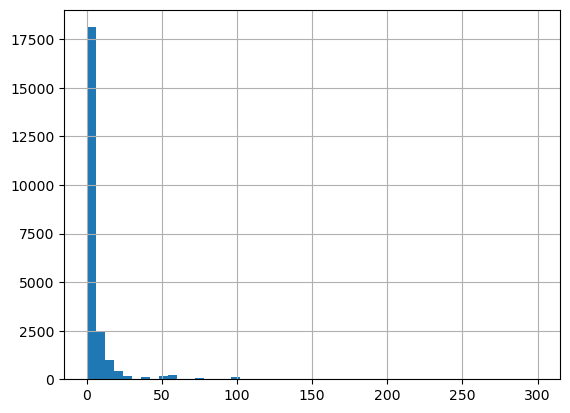

In [50]:
df['MRL'].hist(bins=50)

In [51]:
df.describe()

,amount_detected,MRL
count,22873.000000,22876.000000
mean,0.450757,5.838750
std,1.998795,14.280288
min,0.001000,0.002000
25%,0.020000,0.600000
50%,0.050000,2.000000
75%,0.200000,5.000000
max,63.000000,300.000000


In [52]:
df.to_csv('cleaned_data/joined_data.csv', index=False)